# Hopfield Network

In [1]:
# imports

import numpy as np
from matplotlib import pyplot as plt
from keras.datasets import mnist
from hopfield_experiments import utils
from hopfield_experiments import hopfield
from tqdm import tqdm
from skimage.metrics import mean_squared_error, structural_similarity, peak_signal_noise_ratio
import mplcyberpunk

plt.style.use("cyberpunk")
import gc

seed = 42
np.random.seed(seed)

In [2]:
# setting font size for graphs

SIZE = 14

plt.rc('font', size=SIZE)
plt.rc('axes', titlesize=SIZE)  
plt.rc('axes', labelsize=SIZE)  
plt.rc('xtick', labelsize=SIZE)    
plt.rc('ytick', labelsize=SIZE)  
plt.rc('legend', fontsize=SIZE) 
plt.rc('figure', titlesize=SIZE)

# set color cycle

plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.tab10.colors)

In [3]:
# load mnist data

(X_train, y_train), (X_test, y_test) = mnist.load_data()

train_data = {i:None for i in range(10)}

for i in range(10):
    xi = X_test[y_test==i]
    train_data[i] = xi

## Demo

In [32]:
# get some digits & preprocess

demo_train = []
digits = np.random.randint(0, 10, size=3)

for i in digits:
    demo_train.append(X_train[y_train==i][0])

demo_train = [utils.preprocessing(i) for i in demo_train]

In [33]:
# train model & test with 20% corruption

model = hopfield.HopfieldNetwork()
model.train(demo_train)

demo_test = [utils.get_corrupted_input(x, 0.2) for x in demo_train]
preds = model.predict(demo_test, threshold=120, num_iter=20)

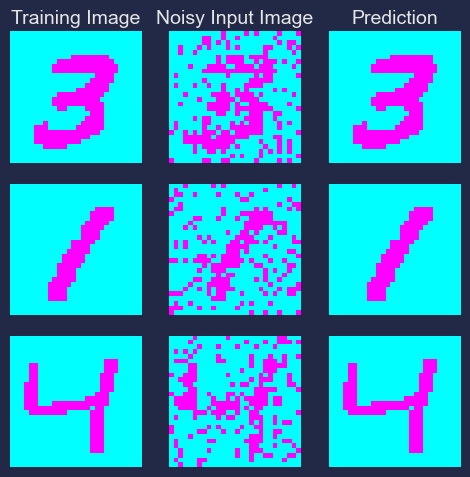

In [34]:
# plot demo samples

utils.plot(demo_train, demo_test, preds)

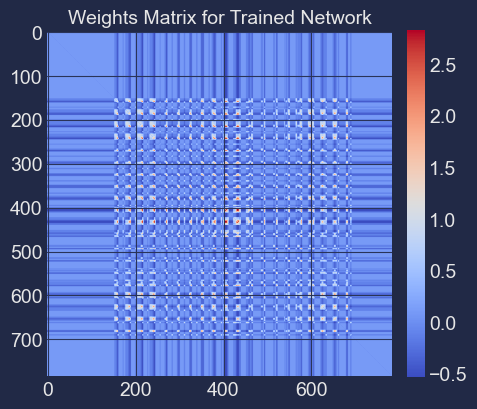

In [35]:
# plot weight matrix

model.plot_weight_matrix()

In [4]:
gc.collect()

228

## Limitation: Spurious States

In [7]:
# get 5 digits & preprocess

demo_train = []
digits = list(range(5))

for i in digits:
    demo_train.append(X_train[y_train==i][0])

demo_train = [utils.preprocessing(i) for i in demo_train]

In [22]:
# train model & test with 20% corruption

model = hopfield.HopfieldNetwork()
model.train(demo_train)

demo_test = [utils.get_corrupted_input(x, 0.2) for x in demo_train]
preds = model.predict(demo_test, threshold=100, num_iter=20)

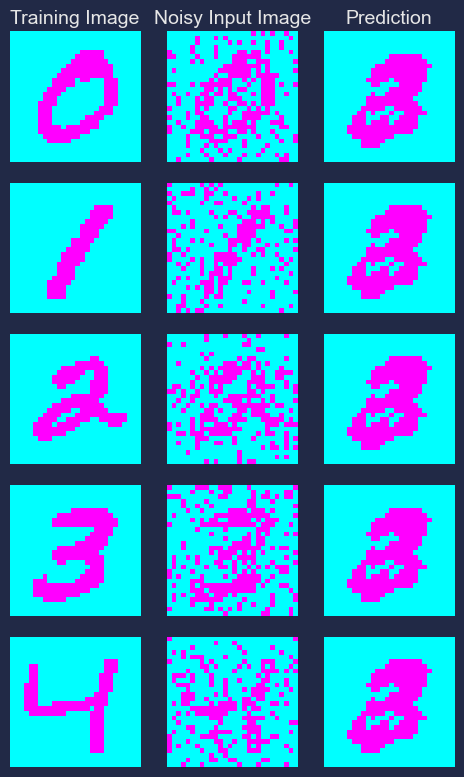

In [23]:
# plot spurious states

utils.plot(demo_train, demo_test, preds, figsize=(5, 8))

In [24]:
gc.collect()

57195

## Evaluation

In [26]:
# define metric dicts and corruption levels (10 to 50%)

mse = {i:[] for i in range(10)}
psnr = {i:[] for i in range(10)}
ssim = {i:[] for i in range(10)}

corruption_levels = np.arange(0, 1.1, 0.1)

In [25]:
gc.collect()

111

In [27]:
# train network and evaluate metrics for digits

for i in tqdm(range(0, 10, 2)):
    
    train_digit1 = train_data[i]
    train_digit2 = train_data[i+1]
    # preprocess data
    train_digit1_processed = [utils.preprocessing(x) for x in train_digit1]
    train_digit2_processed = [utils.preprocessing(x) for x in train_digit2]

    # instantiate model & train
    model = hopfield.HopfieldNetwork()
    model.train(np.append(train_digit1_processed, train_digit2_processed, axis=0))

    # pattern recovery for varying corruption levels
    for corruption in corruption_levels:
        test_digit1 = [utils.get_corrupted_input(x, corruption) for x in train_digit1_processed]
        test_digit2 = [utils.get_corrupted_input(x, corruption) for x in train_digit2_processed]
        
        preds_digit1 = model.predict(test_digit1, threshold=70, num_iter=30)
        preds_digit2 = model.predict(test_digit2, threshold=70, num_iter=30)
        
        mse_digit1, psnr_digit1, ssim_digit1 = 0, 0, 0
        mse_digit2, psnr_digit2, ssim_digit2 = 0, 0, 0
        
        for j in range(len(train_digit1)):
            mse_digit1 += mean_squared_error(train_digit1_processed[j], preds_digit1[j])
            psnr_digit1 += peak_signal_noise_ratio(train_digit1_processed[j], preds_digit1[j].astype('int32'), data_range=255)
            ssim_digit1 += structural_similarity(train_digit1_processed[j], preds_digit1[j].astype('int32'), data_range=255)
        mse[i].append(mse_digit1/len(test_digit1))
        psnr[i].append(psnr_digit1/len(test_digit1))
        ssim[i].append(ssim_digit1/len(test_digit1))
        
        for j in range(len(train_digit2)):
            mse_digit2 += mean_squared_error(train_digit2_processed[j], preds_digit2[j])
            psnr_digit2 += peak_signal_noise_ratio(train_digit2_processed[j], preds_digit2[j].astype('int32'), data_range=255)
            ssim_digit2 += structural_similarity(train_digit2_processed[j], preds_digit2[j].astype('int32'), data_range=255)
        mse[i+1].append(mse_digit2/len(test_digit2))
        psnr[i+1].append(psnr_digit2/len(test_digit2))
        ssim[i+1].append(ssim_digit2/len(test_digit2))
        

100%|██████████| 5/5 [03:31<00:00, 42.26s/it]


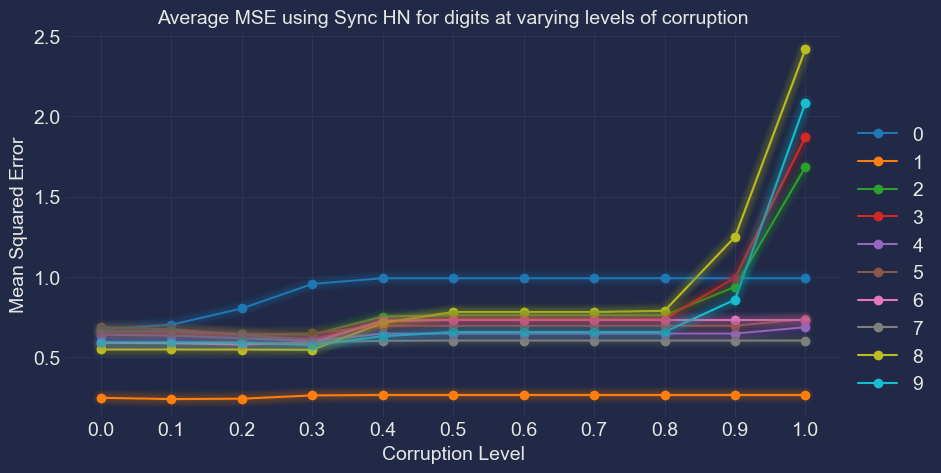

In [30]:
# plot mse

plt.figure(figsize=(10, 5))

for i in range(10):
    plt.plot(corruption_levels, mse[i], label=i, marker='o')

plt.xticks(np.arange(0, 1.1, 0.1))
plt.legend(bbox_to_anchor=(1,0.8))
plt.xlabel("Corruption Level")
plt.ylabel("Mean Squared Error")
plt.title("Average MSE using Sync HN for digits at varying levels of corruption")
mplcyberpunk.make_lines_glow()
plt.show()

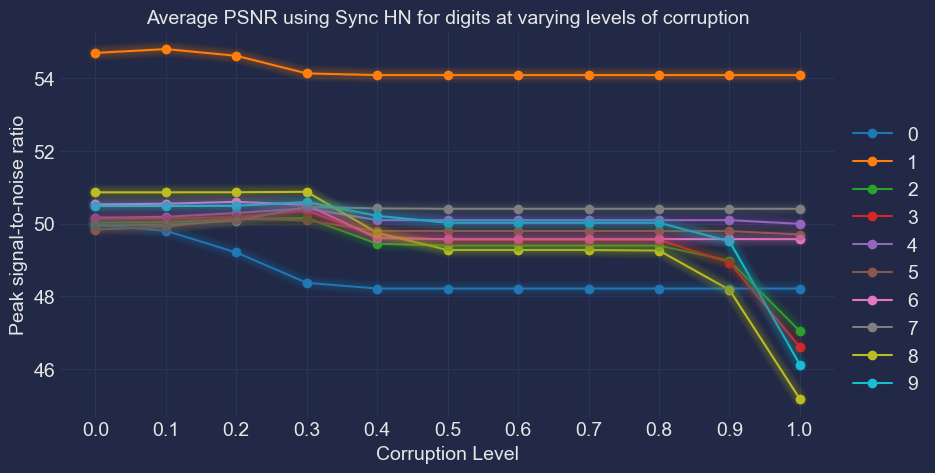

In [33]:
# plot psnr

plt.figure(figsize=(10, 5))

for i in range(10):
    plt.plot(corruption_levels, psnr[i], label=i, marker='o')

plt.xticks(np.arange(0, 1.1, 0.1))
plt.legend(bbox_to_anchor=(1,0.8))
plt.xlabel("Corruption Level")
plt.ylabel("Peak signal-to-noise ratio")
plt.title("Average PSNR using Sync HN for digits at varying levels of corruption")
mplcyberpunk.make_lines_glow()
plt.show()

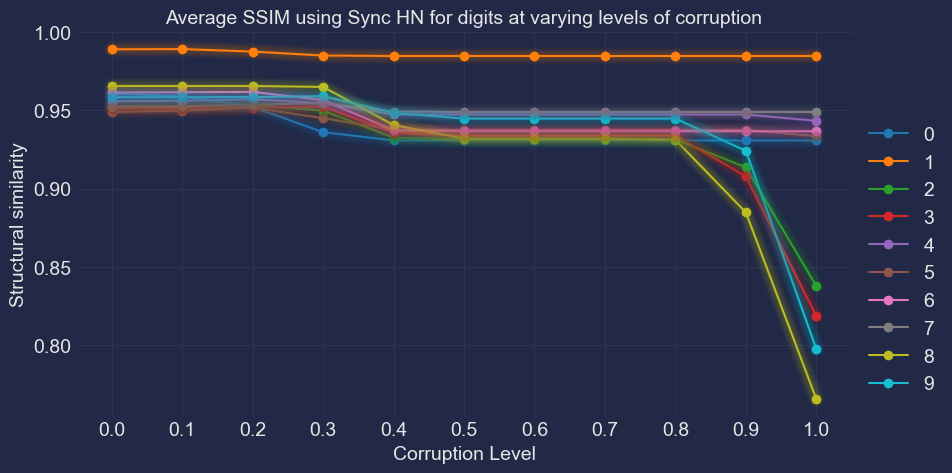

In [34]:
# plot ssim

plt.figure(figsize=(10, 5))

for i in range(10):
    plt.plot(corruption_levels, ssim[i], label=i, marker='o')

plt.xticks(np.arange(0, 1.1, 0.1))
plt.legend(bbox_to_anchor=(1,0.8))
plt.xlabel("Corruption Level")
plt.ylabel("Structural similarity")
plt.title("Average SSIM using Sync HN for digits at varying levels of corruption")
mplcyberpunk.make_lines_glow()
plt.show()

In [35]:
gc.collect()

13606

In [36]:
# save metrics for sharing

import pickle

with open('mse_sync.pkl', 'wb') as f:
    pickle.dump(mse, f)
with open('psnr_sync.pkl', 'wb') as f:
    pickle.dump(psnr, f)
with open('ssim_sync.pkl', 'wb') as f:
    pickle.dump(ssim, f)